# Tesla Superchargers

![image of tesla superchargers](images/tesla-supercharger.png)

This notebook will analyze the Tesla Supercharging Network. This is a network of electric vehicle charging sites located throughout the world. This notebook will focus on the charging sites located in the United States. Some of the questions the notebooks ask are:

* Number of charging sites
  * Breakdown by state
  * Normalize the data using state population to compare dense areas like California with sparsely populated areas like Wyoming. 
  * Compare the output power (150Kw, 250Kw, etc) that determines how long a vehicle has to stay to charge.
* How has the Supercharger sites grown over time?
  * Compare chargers installed by quarter to the number of Tesla vehicles sold.
* The future
  * Supercharger sites are primarily needed for inter state travel. It would be interesting to compare travel volume with the installation of new sites.  
  * The dataset contains predictions of new sites for 2021 and beyond. Analyze the number of new sites. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import Markdown, display

## Data 

The primary data for this notebook comes from Tesla itself. On their website, is the entire dataset of chargers. It is a json file that contains information on all chargers in the world. It includes Superchargers and destination chargers. It has information on current and future expansion.

I have downloaded the json file locally, but the data should be available at the following url.

[Download Tesla All Locations](https://www.tesla.com/all-locations)

In [2]:
# read the tesla json
sites = pd.read_json('input/tesla-all-locations.json')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#print(f"Columns List: {sites.columns}")
print(f"The file contains {sites.shape[0]} rows and {sites.shape[1]} columns ")

# sites.to_csv('output/superchargers.csv')

The file contains 16521 rows and 38 columns 


# Data Dictionary

This data dictionary does not come from Tesla, since the json file on their site is not a documented file by Tesla.  This is just info I learned while analyzing the data. 

## Address Info

* address_line_1
* address_line_2
* address_notes
* address
* city
* province_state - state for US
* postal_code - zip code for US
* country
* region - large region like north america, europe, etc
* sub_region - smaller region like kentucky, united kingdom, etc.

## Geographic Data

* latitude - latitude of the site
* longitude - longitude of the site
* baidu_lat - unknown seems to always be 0.0
* baidu_lng - unknown seems to always be 0.0
* geocode - unknown code (maybe Tesla specific)


## Site Details

* amenities - info on food, restrooms, shoping, etc. 
* chargers - html markup that contains the information about the charging site. This field contains the power level, number of chargers and available hours. 
* common_name - Human readable name of the local area
* date_opened - This comes from the supercharge-info json not the tesla json file. It displays the date the site was opened. This data is supplied by user on the supercharge.info site. 
* hours - hours of operation. This seems to be reserved to stores, service and delivery. 
* emails - seems to be blank
* location_id - Unique identifier of the location.
  * This same location_id id found in the supercharge.info json file
* location_type - List the type of loctaion. Supercharger, Destination Charger, Store, Service, Delivery
* open_soon - indicates if the location is opening soon.
* path - path on the tesla.com site for this location.
* title - name of the supercharger site

## Destination Charger Info

These destination chargers are located at hotels. They offer lower power connections for overnight charging. They are in the dataset, but are not the focus of this analysis.

* destination_charger_logo
* destination_website - destination charger info, usually the hote's website
* directions_link - google maps link 

## Store Related
* is_gallery
* kiosk_pin_x
* kiosk_pin_y
* kiosk_zoom_pin_x
* kiosk_zoom_pin_y
* sales_phone
* sales_representative

## Misc
* nid - unknown, possible a tesla specific identifier
* trt_id - unknown


In [3]:
# General Setting
tesla_red = '#e82127'

In [4]:
# just kentucky chargers
#q = "country == 'United States' & province_state == 'KY' & location_type.str.contains('supercharger', regex=False)"
# I want just USA sites 
q = "country == 'United States' & location_type.str.contains('supercharger', regex = False)" 
us_sites = sites.query(q)

us_sites = us_sites[['title', 'location_id', 'nid', 
                           'address_line_1', 'city', 'province_state', 'postal_code',
                           'chargers', 'common_name', 'open_soon',
                           'latitude', 'longitude', 'location_type']]

# rename some columns
us_sites.rename(columns = {"province_state": "state_code", "postal_code": "zip_code", "address_line_1" : "address"}, inplace = True)

print(f"The US only dataframe contains {us_sites.shape[0]} rows and {us_sites.shape[1]} columns ")
us_sites.head()

The US only dataframe contains 1354 rows and 13 columns 


,title,location_id,nid,address,city,state_code,zip_code,chargers,common_name,open_soon,latitude,longitude,location_type
2,"Albany, NY Supercharger",albanysupercharger,6293,131 Colonie Center,Albany,NY,12205,<p><strong>Charging</strong><br />6 Supercharg...,Colonie Center,0,42.710356,-73.819109,"[supercharger, standard charger]"
3,"Albert Lea, MN Supercharger",albertleasupercharger,6294,811 E Plaza St,Albert Lea,MN,56007,<p><strong>Charging</strong><br />4 Supercharg...,AmericInn Lodge & Suites Albert Lea,0,43.686060,-93.357721,"[supercharger, standard charger]"
4,"Angola, IN Supercharger",angolasupercharger,6298,3855 Indiana 127,Angola,IN,46703,<p><strong>Charging</strong><br />6 Supercharg...,Ramada Angola,0,41.699048,-85.000326,"[supercharger, standard charger]"
6,"Atascadero, CA Supercharger",atascaderosupercharger,6300,6950 El Camino Real,Atascadero,CA,93422,<p><strong>Charging</strong><br />8 Supercharg...,Rabobank,0,35.486585,-120.666378,"[supercharger, standard charger]"
11,"Beaver, UT Supercharger",beaversupercharger,6308,Littlefield Interchange,Beaver,UT,84713,<p><strong>Charging</strong><br/>8 Supercharge...,Beaver Valley Chevron,0,38.249149,-112.652524,"[supercharger, standard charger]"


# Extract data from the chargers HTML

I need to extract some data from a html markup in the chargers column. Specifically I need to extract the number of chargers per site and the power rating (150KW, 250KW)

In [5]:
# add the number of chargers from the html, using regular expresions, this is searching
# for at least 1 digit (0-9) folowed by a space and the word 'Superchargers'. The () around
# the \d+ is a capture group. It will find the pattern but only return the part in the ()
us_sites['num_of_chargers'] = us_sites['chargers'].str.extract(r'(\d+) Superchargers', flags = re.IGNORECASE)

# add the power rate from the html markup
us_sites['power'] = us_sites['chargers'].str.extract(r'(\d+)KW', flags = re.IGNORECASE)
us_sites.head()

,title,location_id,nid,address,city,state_code,zip_code,chargers,common_name,open_soon,latitude,longitude,location_type,num_of_chargers,power
2,"Albany, NY Supercharger",albanysupercharger,6293,131 Colonie Center,Albany,NY,12205,<p><strong>Charging</strong><br />6 Supercharg...,Colonie Center,0,42.710356,-73.819109,"[supercharger, standard charger]",6,150
3,"Albert Lea, MN Supercharger",albertleasupercharger,6294,811 E Plaza St,Albert Lea,MN,56007,<p><strong>Charging</strong><br />4 Supercharg...,AmericInn Lodge & Suites Albert Lea,0,43.686060,-93.357721,"[supercharger, standard charger]",4,150
4,"Angola, IN Supercharger",angolasupercharger,6298,3855 Indiana 127,Angola,IN,46703,<p><strong>Charging</strong><br />6 Supercharg...,Ramada Angola,0,41.699048,-85.000326,"[supercharger, standard charger]",6,150
6,"Atascadero, CA Supercharger",atascaderosupercharger,6300,6950 El Camino Real,Atascadero,CA,93422,<p><strong>Charging</strong><br />8 Supercharg...,Rabobank,0,35.486585,-120.666378,"[supercharger, standard charger]",8,150
11,"Beaver, UT Supercharger",beaversupercharger,6308,Littlefield Interchange,Beaver,UT,84713,<p><strong>Charging</strong><br/>8 Supercharge...,Beaver Valley Chevron,0,38.249149,-112.652524,"[supercharger, standard charger]",8,150


## Open Date

The json file on tesla.com does not include the opening date of the each site. The website supercharge.info contains additional data about each site. This data is maintained by users submitting their experiences to the site. It is not affiliated with Tesla.

Luckily the location_id field in the supercharge-info matches the location_id in the tesla data. I have copied this json file locally, but the newest version should be found at:

## Links
* [All Changes](https://supercharge.info/service/supercharge/allChanges)
* [All Sites](https://supercharge.info/service/supercharge/allSites)

There are two json files. I am using the allSites file. I need to do more research to find out the differences.

In [6]:
# get the location_id, open date from the supercharge.info to merge with the base tesla data

open_info = pd.read_json('input/supercharge-info-allSites.json')
open_info = open_info[['id', 'locationId', 'dateOpened']]

# rename
open_info.rename(columns = {"locationId": "location_id", "dateOpened": "date_opened"}, inplace = True)

print(f"The supercharge-info data contains {open_info.shape[0]} rows and {open_info.shape[1]} columns ")
#print(open_info.shape)
open_info.head()

The supercharge-info data contains 2906 rows and 3 columns 


,id,location_id,date_opened
0,2215,dangjinsupercharger,2019-12-20
1,2216,seoulgangseosupercharger,2019-12-20
2,122,sanjuancapistranosupercharger,2014-05-06
3,125,glenwoodspringssupercharger,2013-09-17
4,126,grandjunctionsupercharger,2014-01-10


In [7]:
# merge the two datasets to add open date to the data
us_sites = pd.merge(us_sites, open_info, how = 'left', on = 'location_id')

us_sites.info()
us_sites.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 0 to 1354
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1355 non-null   object 
 1   location_id      1355 non-null   object 
 2   nid              1355 non-null   int64  
 3   address          1355 non-null   object 
 4   city             1355 non-null   object 
 5   state_code       1348 non-null   object 
 6   zip_code         1355 non-null   object 
 7   chargers         1355 non-null   object 
 8   common_name      1355 non-null   object 
 9   open_soon        1355 non-null   int64  
 10  latitude         1355 non-null   float64
 11  longitude        1355 non-null   float64
 12  location_type    1355 non-null   object 
 13  num_of_chargers  985 non-null    object 
 14  power            984 non-null    object 
 15  id               1042 non-null   float64
 16  date_opened      980 non-null    object 
dtypes: float64(3),

,title,location_id,nid,address,city,state_code,zip_code,chargers,common_name,open_soon,latitude,longitude,location_type,num_of_chargers,power,id,date_opened
0,"Albany, NY Supercharger",albanysupercharger,6293,131 Colonie Center,Albany,NY,12205,<p><strong>Charging</strong><br />6 Supercharg...,Colonie Center,0,42.710356,-73.819109,"[supercharger, standard charger]",6,150,160.0,2014-04-30
1,"Albert Lea, MN Supercharger",albertleasupercharger,6294,811 E Plaza St,Albert Lea,MN,56007,<p><strong>Charging</strong><br />4 Supercharg...,AmericInn Lodge & Suites Albert Lea,0,43.686060,-93.357721,"[supercharger, standard charger]",4,150,152.0,2014-01-15
2,"Angola, IN Supercharger",angolasupercharger,6298,3855 Indiana 127,Angola,IN,46703,<p><strong>Charging</strong><br />6 Supercharg...,Ramada Angola,0,41.699048,-85.000326,"[supercharger, standard charger]",6,150,147.0,2013-12-09
3,"Atascadero, CA Supercharger",atascaderosupercharger,6300,6950 El Camino Real,Atascadero,CA,93422,<p><strong>Charging</strong><br />8 Supercharg...,Rabobank,0,35.486585,-120.666378,"[supercharger, standard charger]",8,150,108.0,2013-07-03
4,"Beaver, UT Supercharger",beaversupercharger,6308,Littlefield Interchange,Beaver,UT,84713,<p><strong>Charging</strong><br/>8 Supercharge...,Beaver Valley Chevron,0,38.249149,-112.652524,"[supercharger, standard charger]",8,150,187.0,2014-04-14


In [8]:
# Add State Fullname for display in visualizations 

# read the csv into a dict for use in replace map
state_codes = pd.read_csv('input/us_state_codes.csv')
state_codes.head()

us_sites = pd.merge(us_sites, state_codes, how = 'inner', on = 'state_code')
us_sites.head()

,title,location_id,nid,address,city,state_code,zip_code,chargers,common_name,open_soon,latitude,longitude,location_type,num_of_chargers,power,id,date_opened,state_name
0,"Albany, NY Supercharger",albanysupercharger,6293,131 Colonie Center,Albany,NY,12205,<p><strong>Charging</strong><br />6 Supercharg...,Colonie Center,0,42.710356,-73.819109,"[supercharger, standard charger]",6,150,160.0,2014-04-30,New York
1,"JFK - Queens, NY Supercharger",jfksupercharger,6407,150th Ave and 147th St,Queens,NY,11430,<p><strong>Charging</strong><br />4 Supercharg...,JFK Airport Travel Plaza,0,40.663190,-73.793192,"[supercharger, standard charger]",4,150,161.0,2013-12-23,New York
2,Utica Supercharger,uticanysupercharger,7654,50 Auert Ave.,Utica,NY,13501,<p><strong>Charging</strong><br />8 supercharg...,North Utica Shopping Center,0,43.113878,-75.206857,"[supercharger, standard charger]",8,150,545.0,2015-02-11,New York
3,Syracuse Supercharger,syracusesupercharger,9018,441 Electronics Parkway,Liverpool,NY,13088,<p><strong>Charging</strong><br />8 supercharg...,Holiday Inn Syracuse/Liverpool,0,43.102424,-76.187446,"[supercharger, standard charger]",8,150,547.0,2015-04-16,New York
4,Buffalo Supercharger,buffalosupercharger,9563,4455 Transit Road,Buffalo,NY,14221,<p><strong>Charging</strong><br />8 supercharg...,Shops at Main / Transit,0,42.968675,-78.695680,"[supercharger, standard charger]",8,150,415.0,2015-06-11,New York


## Population

I want to add state population to the dataset so later on I can normalize the number of sites. 

[Census Data](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_500989927)

In [9]:
# add state population
state_info = pd.read_csv('input/state_population.csv')

us_sites = pd.merge(us_sites, state_info, how = 'inner', on = 'state_name')

# change the data type of the number columns to support math later
us_sites = us_sites.astype({'num_of_chargers' : 'float64', 'power' : 'float64', 'population_2019' : 'float64'})
us_sites.head()

,title,location_id,nid,address,city,state_code,zip_code,chargers,common_name,open_soon,latitude,longitude,location_type,num_of_chargers,power,id,date_opened,state_name,population_2019
0,"Albany, NY Supercharger",albanysupercharger,6293,131 Colonie Center,Albany,NY,12205,<p><strong>Charging</strong><br />6 Supercharg...,Colonie Center,0,42.710356,-73.819109,"[supercharger, standard charger]",6.0,150.0,160.0,2014-04-30,New York,19453561.0
1,"JFK - Queens, NY Supercharger",jfksupercharger,6407,150th Ave and 147th St,Queens,NY,11430,<p><strong>Charging</strong><br />4 Supercharg...,JFK Airport Travel Plaza,0,40.663190,-73.793192,"[supercharger, standard charger]",4.0,150.0,161.0,2013-12-23,New York,19453561.0
2,Utica Supercharger,uticanysupercharger,7654,50 Auert Ave.,Utica,NY,13501,<p><strong>Charging</strong><br />8 supercharg...,North Utica Shopping Center,0,43.113878,-75.206857,"[supercharger, standard charger]",8.0,150.0,545.0,2015-02-11,New York,19453561.0
3,Syracuse Supercharger,syracusesupercharger,9018,441 Electronics Parkway,Liverpool,NY,13088,<p><strong>Charging</strong><br />8 supercharg...,Holiday Inn Syracuse/Liverpool,0,43.102424,-76.187446,"[supercharger, standard charger]",8.0,150.0,547.0,2015-04-16,New York,19453561.0
4,Buffalo Supercharger,buffalosupercharger,9563,4455 Transit Road,Buffalo,NY,14221,<p><strong>Charging</strong><br />8 supercharg...,Shops at Main / Transit,0,42.968675,-78.695680,"[supercharger, standard charger]",8.0,150.0,415.0,2015-06-11,New York,19453561.0


# Visualizations

In [10]:
%matplotlib inline

# function for a bar chart
def bar_chart(x, y, x_label, y_label, title, color):

    # make a bar chart
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, zorder=10)
    ax.bar(x, y, color=color)

    # text
    ax.set_title(title, fontsize = 18)
    ax.set_xlabel(x_label, fontsize = 8, fontweight = 'bold')
    ax.set_xticklabels(x, rotation=45)

    ax.set_ylabel(y_label, fontsize = 8, fontweight = 'bold')
    ax.legend(['Count'])

    # totally ripped off, i need to better understand what is happening 
    for i in range(len(y)):
        ax.annotate(str(y[i]), xy=(x[i], y[i]), ha='center', va='bottom', color='black')

    # grids on
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    ax.grid(color = 'gray', linestyle = 'solid', alpha = 0.2)

    plt.show()

# Number of Chargers and Sites by State

In [11]:
# Only get open chargers
q = 'open_soon == 0'
open_us_sites = us_sites.query(q)

In [12]:
# count and sum the number of chargers and sites
# average the population
state_counts = open_us_sites.groupby('state_name') \
    .agg(charger_count=('num_of_chargers', 'sum'),
         site_count=('num_of_chargers', 'count'),
         population=('population_2019', 'mean')) \

# people per charger
state_counts['pop_per_charger'] = state_counts['population'] / state_counts['charger_count'] 
state_counts = state_counts.astype(int) # make everything integers
state_counts.head()

,charger_count,site_count,population,pop_per_charger
state_name,,,,
Alabama,56,7,4903185,87556
Arizona,228,22,7278717,31924
Arkansas,26,3,3017804,116069
California,2923,202,39512223,13517
Colorado,225,26,5758736,25594


<ipython-input-10-4b8bdb025340>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45)


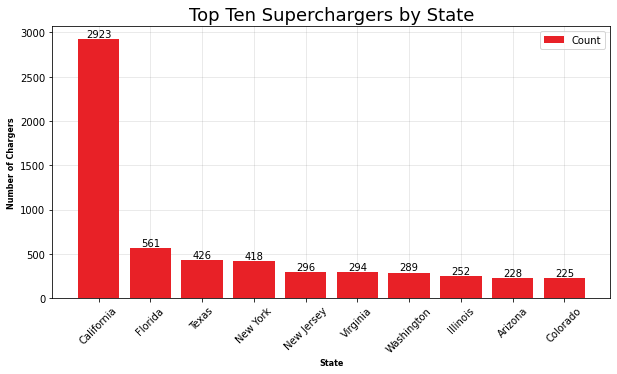

In [13]:
# Chargers 
top_ten_chargers = state_counts.sort_values(by=['charger_count'], ascending = False)[:10]

# get the data in a series for plotting
states = top_ten_chargers.index.values.tolist() 
count = top_ten_chargers.charger_count.values.tolist()

# plot it
bar_chart(states, count, 'State', 'Number of Chargers', 'Top Ten Superchargers by State', tesla_red)

<ipython-input-10-4b8bdb025340>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45)


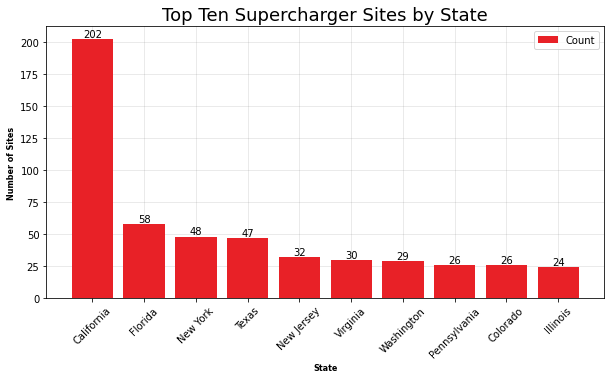

In [14]:
# Sites 
top_ten_sites = state_counts.sort_values(by=['site_count'], ascending = False)[:10]

# get the data in a series for plotting
states = top_ten_sites.index.values.tolist() 
count = top_ten_sites.site_count.values.tolist()

# plot it
bar_chart(states, count, 'State', 'Number of Sites', 'Top Ten Supercharger Sites by State', tesla_red)

<ipython-input-10-4b8bdb025340>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45)


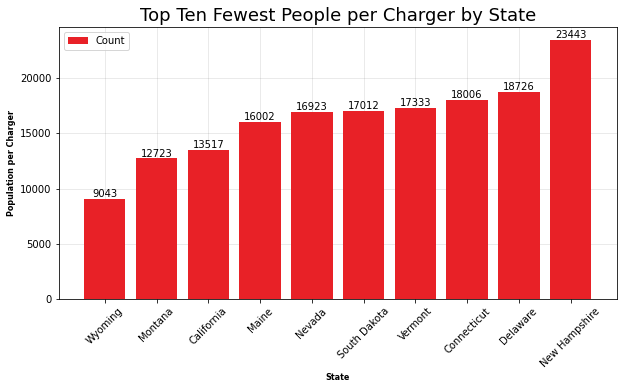

In [15]:
# Population 
top_ten_pop = state_counts.sort_values(by=['pop_per_charger'], ascending = True)[:10]

# get the data in a series for plotting
states = top_ten_pop.index.values.tolist() 
pop = top_ten_pop.pop_per_charger.values.tolist()

# plot it
bar_chart(states, pop, 'State', 'Population per Charger', 'Top Ten Fewest People per Charger by State', tesla_red)

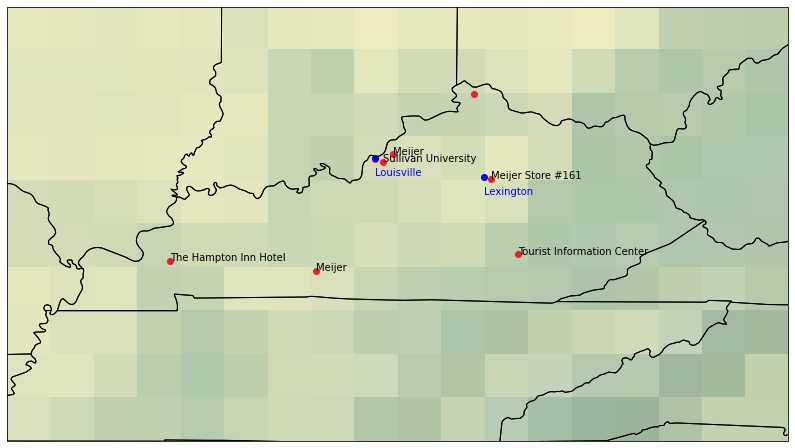

In [16]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cartopy.io.shapereader as shpreader
#import cartopy.io.img_tiles as cimgt
#import cartopy.mpl.geoaxes
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#%matplotlib inline

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.stock_img() # pretty map
ax.coastlines()
ax.add_feature(cfeature.STATES)

# map extents
extent = [-135, -66.5, 20, 55] # United States
extent = [-90, -81, 35, 40] # Kentucky
ax.set_extent(extent, crs=ccrs.PlateCarree()) ## Important

# get ky chargers only
ky_chargers = us_sites[us_sites.state_code == "KY"]
# add chargers
plt.scatter(ky_chargers.longitude, ky_chargers.latitude, color=tesla_red, alpha=1, transform=ccrs.PlateCarree())

for index, row in ky_chargers.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    name = row['common_name']
    ax.text(lon, lat, name, transform=ccrs.PlateCarree())

# Add some cities in the area
plt.scatter(-85.7585, 38.2527, color='blue', alpha=1, transform=ccrs.PlateCarree())
ax.text(-85.7585, 38.2527 - 0.2, 'Louisville', color='blue', transform=ccrs.PlateCarree())

plt.scatter(-84.5037, 38.0406 , color='blue', alpha=1, transform=ccrs.PlateCarree())
ax.text(-84.5037, 38.0406 - 0.2, 'Lexington', color='blue', transform=ccrs.PlateCarree())

plt.show()

## Create a requirements.txt file

```
pip list --format=freeze > requirements.txt
```

# Next Steps
* Maps
* Heat map of charger locations
  * You can heat map the count, but it might be interesting to heat map the power levels counts
  * This could be a figure that has multiple subplots
  * color the lower counts red and the higher population blue. Can I even do this
* Number of chargers open by month
  * Can I combine this with number of cars produced by month. I think they release these numbers as part of their quarterly financial statement.
* Compare population of state to number of superchargers to normalize. Hint California is still way over
* Pratik showed a box plot
* Compared to sales by state if available
* Animation of the chargers by open date. 
  * plt.annotate could show all the dates as the plot refreshes
* Pratik suggested to categorize the populations like < 1 million, 2-4, 5-10, 10+
* Also try to get the requirements.txt file generated.
* Other visualization Tools
  * Seaborn
  * dash (dashboard tool)
  * plotly
* Can I aggragate the count of chargers with the average of state population
  * In SQL it woudl be statename, count(*), avg(population)... group by statename

# Notes
* Check for outliers (don't throw it out if it is valid)
* When doing correlations just pick the data that you think will have correlation
* ax, plt what is this. He said that ax is the axis
* Discrete vs Continuous Data
* make a notebook of often used pandas
  * make functions ( how can I include this in a single import)i
* Dates can maybe be converted to something meaningful by saying the number of days since the event


In [17]:
us_sites.info()
us_sites.describe()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 1322
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1323 non-null   object 
 1   location_id      1323 non-null   object 
 2   nid              1323 non-null   int64  
 3   address          1323 non-null   object 
 4   city             1323 non-null   object 
 5   state_code       1323 non-null   object 
 6   zip_code         1323 non-null   object 
 7   chargers         1323 non-null   object 
 8   common_name      1323 non-null   object 
 9   open_soon        1323 non-null   int64  
 10  latitude         1323 non-null   float64
 11  longitude        1323 non-null   float64
 12  location_type    1323 non-null   object 
 13  num_of_chargers  956 non-null    float64
 14  power            955 non-null    float64
 15  id               1012 non-null   float64
 16  date_opened      950 non-null    object 
 17  state_name    

,nid,open_soon,latitude,longitude,num_of_chargers,power,id,population_2019
count,1323.000000,1323.000000,1323.000000,1323.000000,956.000000,955.000000,1012.000000,1.323000e+03
mean,37443.019652,0.275888,38.093102,-96.047665,9.919456,161.356021,1431.908103,1.661430e+07
std,17425.364043,0.447130,4.991971,18.745237,4.932932,54.278080,777.598641,1.405378e+07
min,6293.000000,0.000000,20.888030,-157.860336,2.000000,72.000000,100.000000,5.787590e+05
25%,28528.000000,0.000000,34.319534,-117.493473,8.000000,150.000000,769.500000,5.758736e+06
50%,34706.000000,0.000000,38.782160,-91.154637,8.000000,150.000000,1531.500000,1.048808e+07
75%,55708.500000,1.000000,41.345904,-78.911811,12.000000,150.000000,2099.250000,2.899588e+07
max,57618.000000,1.000000,60.487024,-67.348038,56.000000,250.000000,2767.000000,3.951222e+07
